In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPool2D, Dense, GlobalAveragePooling2D,Flatten,MaxPooling2D
from keras.models import load_model,Model

In [48]:
def conv3x3(filters, stride=1):
    return Conv2D(filters, kernel_size=(3,3), strides=stride, padding='same', use_bias=False)

def inception_module(inputs, num_filters):
    # 1x1 convolution branch
    conv1 = Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(inputs)
    
    # 3x3 convolution branch
    conv3 = Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(inputs)
    conv3 = Conv2D(num_filters, kernel_size=(3, 3), padding='same', activation='relu')(conv3)
    
    # Max pooling branch
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    pool = Conv2D(num_filters, kernel_size=(1, 1), activation='relu')(pool)
    
    # Concatenate outputs from all branches
    outputs = tf.keras.layers.concatenate([conv1, conv3, pool], axis=-1)
    
    return outputs

def residual_block(x, filters, downsample=False):
    shortcut = x
    stride = 1
    if downsample:
        stride = 2
        shortcut = Conv2D(filters, kernel_size=(1,1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = conv3x3(filters, stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv3x3(filters)(x)
    x = BatchNormalization()(x)
    
    x = tf.keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet_inception_block(x, filters, downsample=False):
    shortcut = x
    stride = 1
    
    if downsample:
        stride = 2
        shortcut = Conv2D(filters, kernel_size=(1,1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = inception_module(x, num_filters=filters)
    x = conv3x3(filters, stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = inception_module(x, num_filters=filters)
    if shortcut.shape[-1] != x.shape[-1]:
        x = tf.keras.layers.Conv2D(filters=shortcut.shape[-1], kernel_size=1)(x)
    x = tf.keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    
    return x

# def ResInception(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
    
#     # Initial convolution layer
#     x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
#     x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
#     # Residual blocks
#     x = residual_block(x, 64, downsample=False)
#     x = inception_module(x, 64)
#     x = residual_block(x, 64, downsample=False)
#     x = inception_module(x, 64)
#     x = residual_block(x, 128, downsample=True)
#     x = inception_module(x, 128)
#     x = residual_block(x, 128, downsample=False)
#     x = inception_module(x, 128)
#     x = residual_block(x, 256, downsample=True)
#     x = inception_module(x, 256)
#     x = residual_block(x, 256, downsample=False)
#     x = inception_module(x, 256)
#     x = residual_block(x, 512, downsample=True)
#     x = inception_module(x, 512)
#     x = residual_block(x, 512, downsample=False)
    
#     # Final classification layers
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = GlobalAveragePooling2D()(x)
#     x = Flatten()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

def InceptResNet(input_shape=(224,224,3), num_classes=1000):
    inputs = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)


    x = resnet_inception_block(x, filters=64, downsample=True)
    x = resnet_inception_block(x, filters=64, downsample=False)
    x = resnet_inception_block(x, filters=128, downsample=True)
    x = resnet_inception_block(x, filters=128, downsample=False)
    x = resnet_inception_block(x, filters=256, downsample=True)
    x = resnet_inception_block(x, filters=256, downsample=False)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [3]:
# Define function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image
    img = load_img(image_path, target_size=(64, 64))
    # Convert image to array
    img_arr = img_to_array(img)
    # Normalize pixel values
    img_arr = img_arr / 255.0
    # Return preprocessed image
    return img_arr

In [4]:
# Define paths to image directory and label csv file
image_dir = 'Cell_Data/Cell_Images/cells'
label_file = 'Cell_Data/label.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [5]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [6]:
# Save preprocessed images as numpy arrays
np.save('train_images.npy', train_images)
np.save('test_images.npy', test_images)
np.save('train_labels.npy', np.array(train_labels))
np.save('test_labels.npy', np.array(test_labels))


In [7]:
# train_images = np.load('train_images.npy')
# test_images = np.load('test_images.npy')
# train_labels = np.load('train_labels.npy')
# test_labels = np.load('test_labels.npy')

In [49]:
model = InceptResNet(input_shape=(64, 64, 3), num_classes=7)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_269 (Conv2D)            (None, 32, 32, 64)   9472        ['input_22[0][0]']               
                                                                                                  
 batch_normalization_69 (BatchN  (None, 32, 32, 64)  256         ['conv2d_269[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_69[0]

In [50]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()

In [51]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_inceptRes_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/5
1269/1269 [==============================] - 686s 528ms/step - loss: 0.6348 - accuracy: 0.7589 - val_loss: 0.6748 - val_accuracy: 0.7467
Epoch 2/5
1269/1269 [==============================] - 669s 528ms/step - loss: 0.3834 - accuracy: 0.8558 - val_loss: 0.4279 - val_accuracy: 0.8579
Epoch 3/5
1269/1269 [==============================] - 645s 508ms/step - loss: 0.3137 - accuracy: 0.8842 - val_loss: 0.4269 - val_accuracy: 0.8434
Epoch 4/5
1269/1269 [==============================] - 658s 519ms/step - loss: 0.2743 - accuracy: 0.8981 - val_loss: 0.4196 - val_accuracy: 0.8423
Epoch 5/5
1269/1269 [==============================] - 669s 527ms/step - loss: 0.2420 - accuracy: 0.9087 - val_loss: 0.3343 - val_accuracy: 0.8741


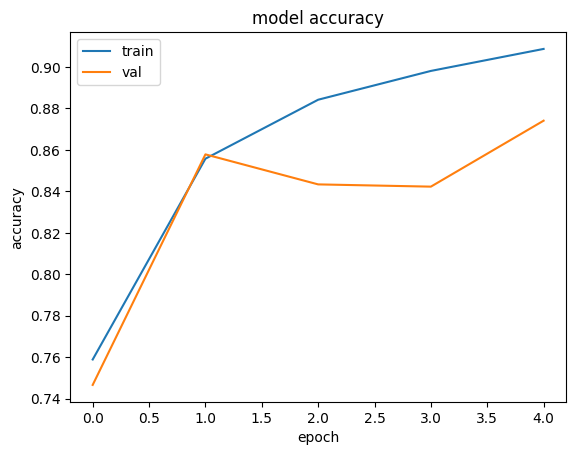

In [52]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

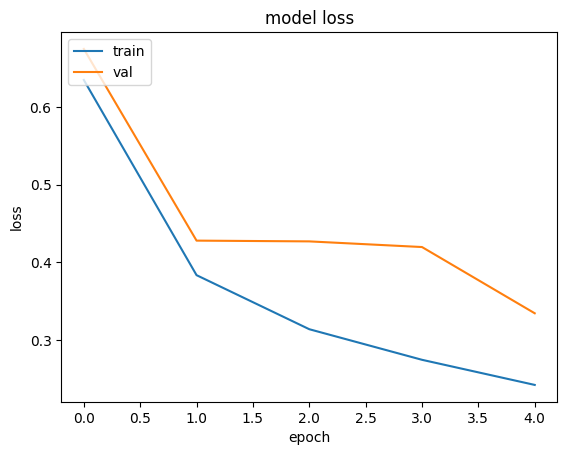

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
best_model = load_model('best_inceptRes_model.h5')

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

397/397 [==============================] - 36s 88ms/step - loss: 0.3271 - accuracy: 0.8743
Test loss: 0.3270896077156067
Test accuracy: 0.8743005990982056


In [55]:
result = model.predict(test_images,)
y_test = np.argmax(result, axis=1)


397/397 [==============================] - 35s 87ms/step


In [56]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[2696   96   32    2   33    1]
 [ 592 2026   79  142   33    2]
 [  52   35 2574   12   12    1]
 [   6   38  105 2589    6    1]
 [ 145   34   33    5  782    8]
 [   2   17   36    3   32  427]]


In [57]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

Class 1
True Positives (TP):  2696
True Negatives (TN):  9032
False Positives (FP):  797
False Negatives (FN):  164
Class 2
True Positives (TP):  2026
True Negatives (TN):  9595
False Positives (FP):  220
False Negatives (FN):  848
Class 3
True Positives (TP):  2574
True Negatives (TN):  9718
False Positives (FP):  285
False Negatives (FN):  112
Class 4
True Positives (TP):  2589
True Negatives (TN):  9780
False Positives (FP):  164
False Negatives (FN):  156
Class 5
True Positives (TP):  782
True Negatives (TN):  11566
False Positives (FP):  116
False Negatives (FN):  225
Class 6
True Positives (TP):  427
True Negatives (TN):  12159
False Positives (FP):  13
False Negatives (FN):  90


In [58]:
from sklearn.metrics import classification_report

# Get the classification report
cr = classification_report(y_true, y_pred, digits=4)

print(cr)

              precision    recall  f1-score   support

           1     0.7718    0.9427    0.8487      2860
           2     0.9020    0.7049    0.7914      2874
           3     0.9003    0.9583    0.9284      2686
           4     0.9404    0.9432    0.9418      2745
           5     0.8708    0.7766    0.8210      1007
           6     0.9705    0.8259    0.8924       517

    accuracy                         0.8743     12689
   macro avg     0.8926    0.8586    0.8706     12689
weighted avg     0.8809    0.8743    0.8723     12689

